In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
import torch
from torch import nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import time
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
img_size = 224



train_dir = r"C:\Users\dmin\HUST\20242\Image-Deepfake-Detection-Training\cifake\train"
test_dir = r"C:\Users\dmin\HUST\20242\Image-Deepfake-Detection-Training\cifake\test"


base_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])



base_train_dataset = datasets.ImageFolder(root=train_dir, transform=base_transform)
targets = np.array([label for _, label in base_train_dataset])
num_classes = len(base_train_dataset.class_to_idx)

print(f'Training dataset has {len(base_train_dataset)} images')
print(f'Training dataset has {num_classes} labels')
print(f'Class to index mapping: {base_train_dataset.class_to_idx}')




train_dataset = ConcatDataset([base_train_dataset]) 
#doan nay muon them augmentation data thi thay = ConcatDataset([base_train_dataset, rotated_90_dataset,......])


val_dataset = datasets.ImageFolder(root=test_dir, transform=base_transform)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


train_targets = [label for _, label in base_train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Training samples (augmented): {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training dataset has 100000 images
Training dataset has 2 labels
Class to index mapping: {'FAKE': 0, 'REAL': 1}
Training samples (augmented): 100000
Validation samples: 20000


In [4]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights, EfficientNet_B3_Weights, ConvNeXt_Base_Weights

# Option 1: ResNet50 (Recommended for deepfake detection)
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        if pretrained:
            self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [5]:
model = ResNet50Classifier(num_classes=num_classes, pretrained=True)
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_parameters:,}")
# Learning Rate Scheduler with ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=30, verbose=True)

Total number of parameters: 24,558,146


c:\Users\dmin\anaconda3\anaconda\envs\test_env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
print(f"Model: {model.__class__.__name__}")
print(f"Criterion: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Scheduler: {scheduler.__class__.__name__}")

Model: ResNet50Classifier
Criterion: CrossEntropyLoss
Optimizer: Adam
Scheduler: ReduceLROnPlateau


In [7]:
import copy

def test_the_model(model, test_dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    # Disable gradient calculation during testing
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)

            
            loss = criterion(outputs, labels)
            #Get the top k predicted labels for each sample
            _, topk_preds = torch.topk(probabilities, k=1, dim=1)
            #Check if the true label is in the top k predicted labels
            correct += torch.sum(topk_preds.eq(labels.view(-1, 1))).item()
            total += labels.size(0)
            running_loss += loss.item()

    #accuracy of top k prediction
    accuracy = (correct / total) * 100
    avg_loss = running_loss / len(test_dataloader)
    return accuracy, avg_loss



def train_the_model(num_epochs=5, grad_clip=1.0):
    accuracies = []
    test_accuracies = []
    max_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train() 
        correct = 0
        total = 0
        running_loss = 0.0
        start_epoch = time.time()

        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        time_complete_epoch = time.time() - start_epoch
        train_accuracy = (correct / total) * 100
        accuracies.append(train_accuracy)

        
        test_accuracy, test_loss = test_the_model(model, val_dataloader)
        test_accuracies.append(test_accuracy)

        # Reduce learning rate based on validation loss
        scheduler.step(test_loss)

        
        if test_accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = test_accuracy
            print(f"Saving best model with Test Accuracy: {test_accuracy:.2f}%")
        
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {running_loss / len(train_dataloader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.2f}%, "
              f"Time: {time_complete_epoch:.2f} seconds")

    #plot the accuracies
    plt.plot(accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Testing Accuracy Over Epochs")
    plt.legend()
    plt.show()

    return best_model

Saving best model with Test Accuracy: 97.18%
Epoch 1/100, Train Loss: 0.1390, Train Accuracy: 94.59%, Test Loss: 0.0747, Test Accuracy: 97.18%, Time: 442.41 seconds
Epoch 2/100, Train Loss: 0.0780, Train Accuracy: 97.09%, Test Loss: 0.0872, Test Accuracy: 96.69%, Time: 442.42 seconds
Saving best model with Test Accuracy: 97.87%
Epoch 3/100, Train Loss: 0.0598, Train Accuracy: 97.83%, Test Loss: 0.0584, Test Accuracy: 97.87%, Time: 455.61 seconds
Epoch 4/100, Train Loss: 0.0489, Train Accuracy: 98.21%, Test Loss: 0.0746, Test Accuracy: 97.27%, Time: 441.71 seconds
Epoch 5/100, Train Loss: 0.0418, Train Accuracy: 98.50%, Test Loss: 0.0788, Test Accuracy: 97.30%, Time: 438.32 seconds
Saving best model with Test Accuracy: 97.89%
Epoch 6/100, Train Loss: 0.0391, Train Accuracy: 98.62%, Test Loss: 0.0618, Test Accuracy: 97.89%, Time: 437.79 seconds
Epoch 7/100, Train Loss: 0.0362, Train Accuracy: 98.72%, Test Loss: 0.0591, Test Accuracy: 97.82%, Time: 437.18 seconds
Saving best model with Te

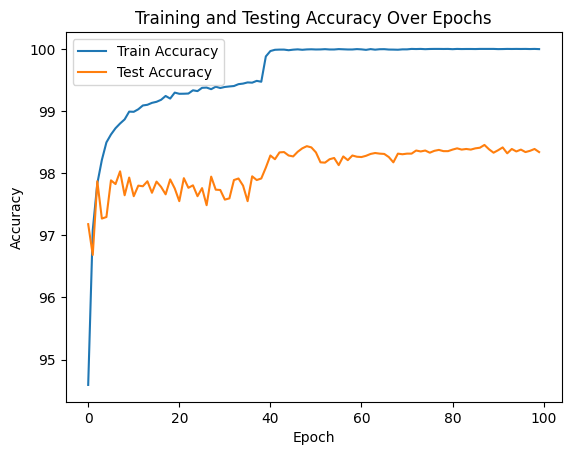

Training time: 810.5526035030683 minutes.


In [8]:
start_training_time = time.time()
result_model = train_the_model(100)
print(f'Training time: {(time.time() - start_training_time) / 60} minutes.')

In [9]:
from sklearn.metrics import classification_report


def get_predictions(model, val_dataloader, device):
    model.eval()  
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return all_labels, all_preds


true_labels, predicted_labels = get_predictions(result_model, val_dataloader, device)


report = classification_report(true_labels, predicted_labels, target_names= base_train_dataset.classes)
print(report)

              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.98     10000
        REAL       0.99      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [11]:
#torch.save(result_model.state_dict(), 'cifake_resNet_98.45.pth')